In [1]:
# we want to be able to import zvar_utils from the parent directory
import glob
import sys
sys.path.append("..")

try:
    import fpw # (needs to be installed from a .whl generated by Sam)
except ImportError:
    print("Could not import fpw. You will not be able to use the fpw module.")
    pass
import numpy as np
from astropy.timeseries import LombScargle

from zvar_utils.candidate import import_from_csv
from zvar_utils.lightcurves import freq_grid, retrieve_objs_lightcurve
from zvar_utils.plot import plot_hr_diagram, plot_folded_lightcurve, plot_periodicity
from zvar_utils.files import get_ssh_client

/Users/theodlz/projects/ZVAR-Utilities/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# first we initialize some variables
# we need to find the files locally and remotely
path_lc = '../data/zvar/lc'
remote_path_lc = '/data/zvar/matchfiles'

host = 'magnetar.caltech.edu'

# if you want to use an ssh client to connect to the remote host,
# you can optionally provide a username and password
# if you do not a password, you have to provide the path
# to your private key instead
username = 'tdulaz'
# password = '<your_password>'
pkey_path = '/Users/theodlz/.ssh/magnetar'

# ssh_client = get_ssh_client(host, username, password)
ssh_client = get_ssh_client(host, username=username, pkey_path=pkey_path)

In [3]:
band = 'r'
field = '0648'
cand_files = glob.glob(f'../data/variability_candidates/{field}/*_z{band}.csv', recursive=True)
candidate_list = []
for file in cand_files:
    candidate_list.extend(import_from_csv(file))
            
print(f"Loaded {len(candidate_list)} candidates, from {len(cand_files)} files")

Loaded 1124 candidates, from 1 files


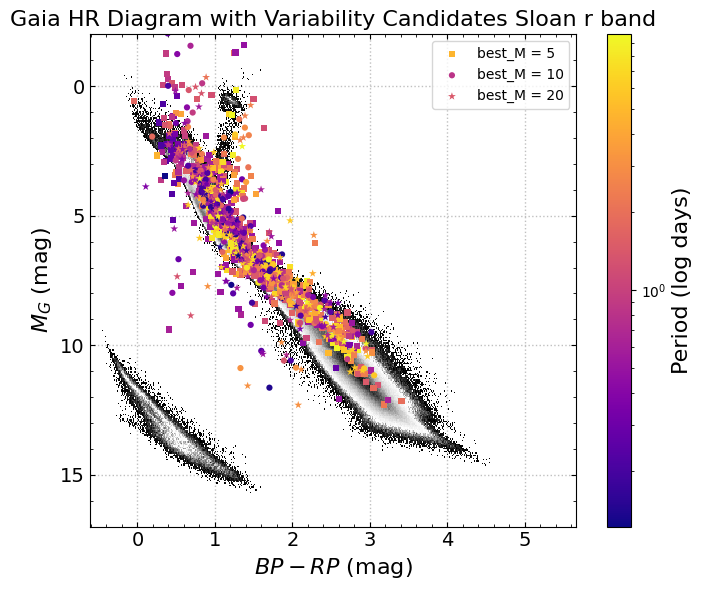

In [4]:
plot_hr_diagram(candidate_list, band, show_plot=True, figsize=(7,6))

In [5]:
red_candidates = []
for candidate in candidate_list:
    if (candidate.gaia.BP_RP is not None) and (candidate.gaia.BP_RP > 3):
        red_candidates.append(candidate)
red_candidates = sorted(red_candidates, key=lambda x: x.fap)
print(f"Found {len(red_candidates)} red candidates")

wd_candidates = []
for candidate in candidate_list:
    if (candidate.gaia.BP_RP is not None) and (candidate.gaia.BP_RP < 2) and (candidate.gaia.MG is not None) and (candidate.gaia.MG > 10):
        wd_candidates.append(candidate)
wd_candidates = sorted(wd_candidates, key=lambda x: x.fap)
print(f"Found {len(wd_candidates)} white dwarf candidates")

giant_candidates = []
for candidate in candidate_list:
    if (candidate.gaia.BP_RP is not None) and (candidate.gaia.BP_RP > 1) and (candidate.gaia.MG is not None) and (candidate.gaia.MG < 3):
        giant_candidates.append(candidate)
giant_candidates = sorted(giant_candidates, key=lambda x: x.fap)
print(f"Found {len(giant_candidates)} giant candidates")

#Short period candidates are anything with a period less than 1 hour
short_candidates = []
for candidate in candidate_list:
    if 1/candidate.freq < 1/24:
        short_candidates.append(candidate)
short_candidates = sorted(short_candidates, key=lambda x: x.fap)
print(f"Found {len(short_candidates)} short period candidates")


Found 11 red candidates
Found 9 white dwarf candidates
Found 27 giant candidates
Found 7 short period candidates


/Users/theodlz/projects/ZVAR-Utilities/notebooks/../zvar_utils/plot.py:158: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


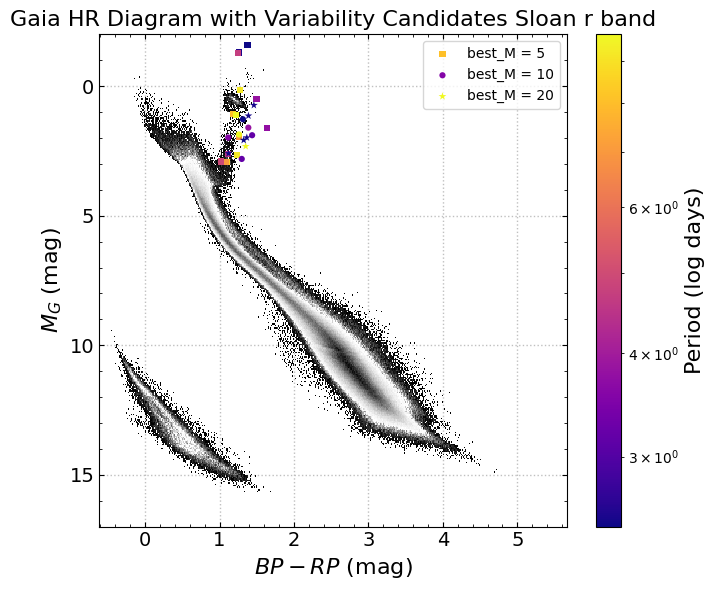

In [6]:
plot_hr_diagram(giant_candidates, band, show_plot=True, figsize=(7,6)) # focus on short period candidates

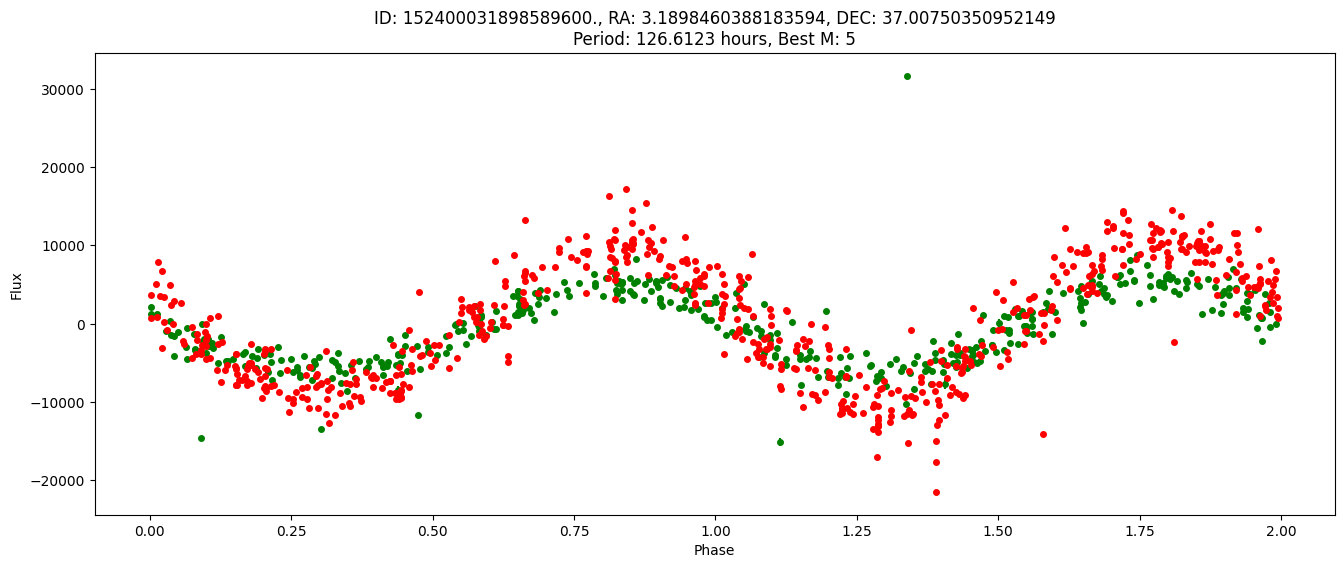

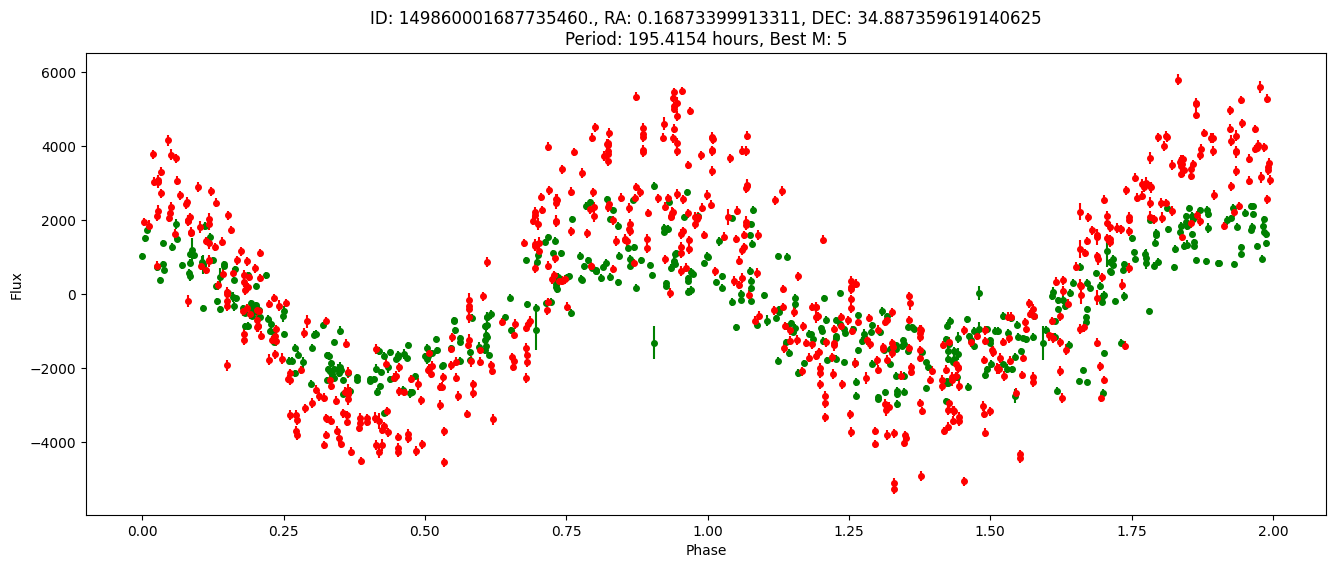

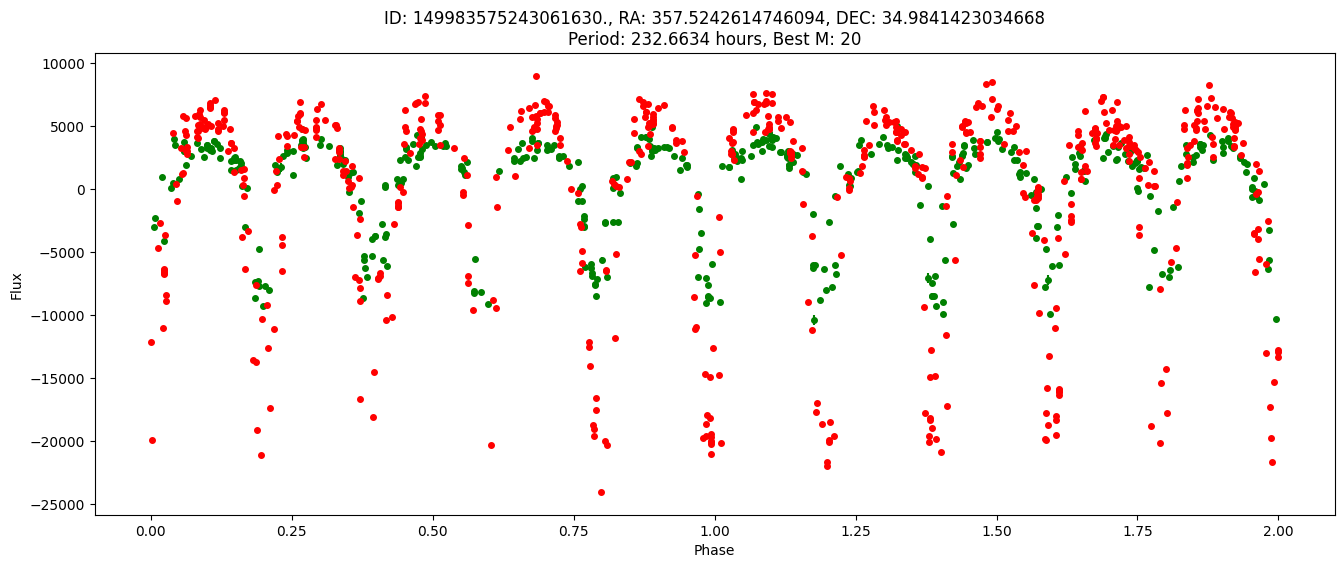

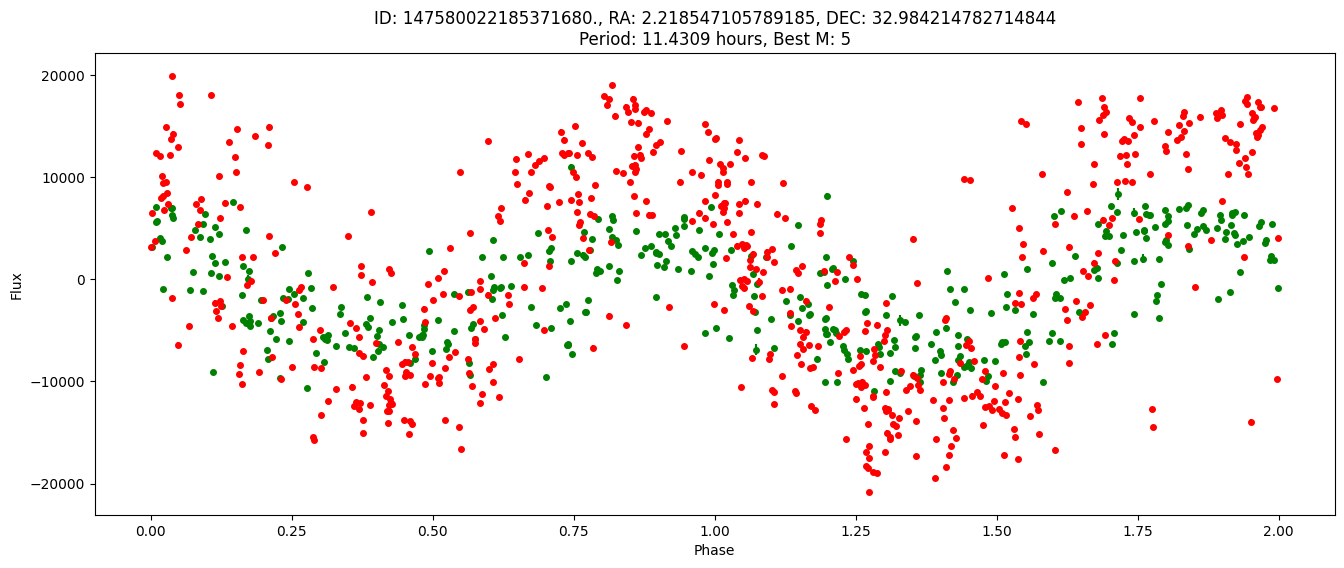

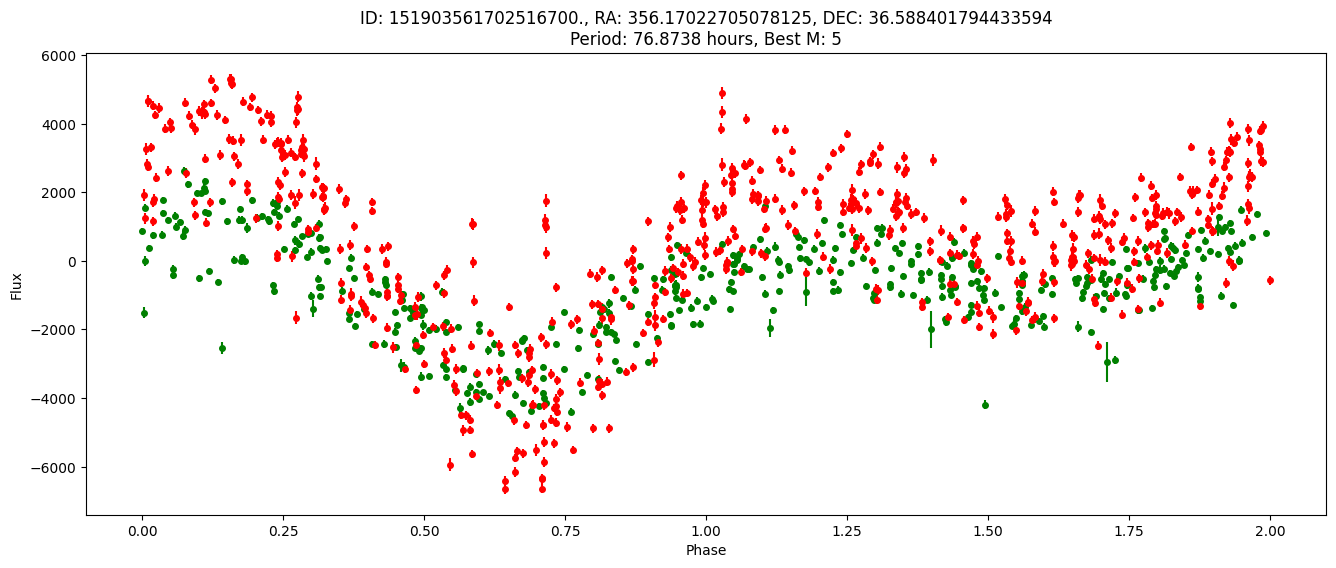

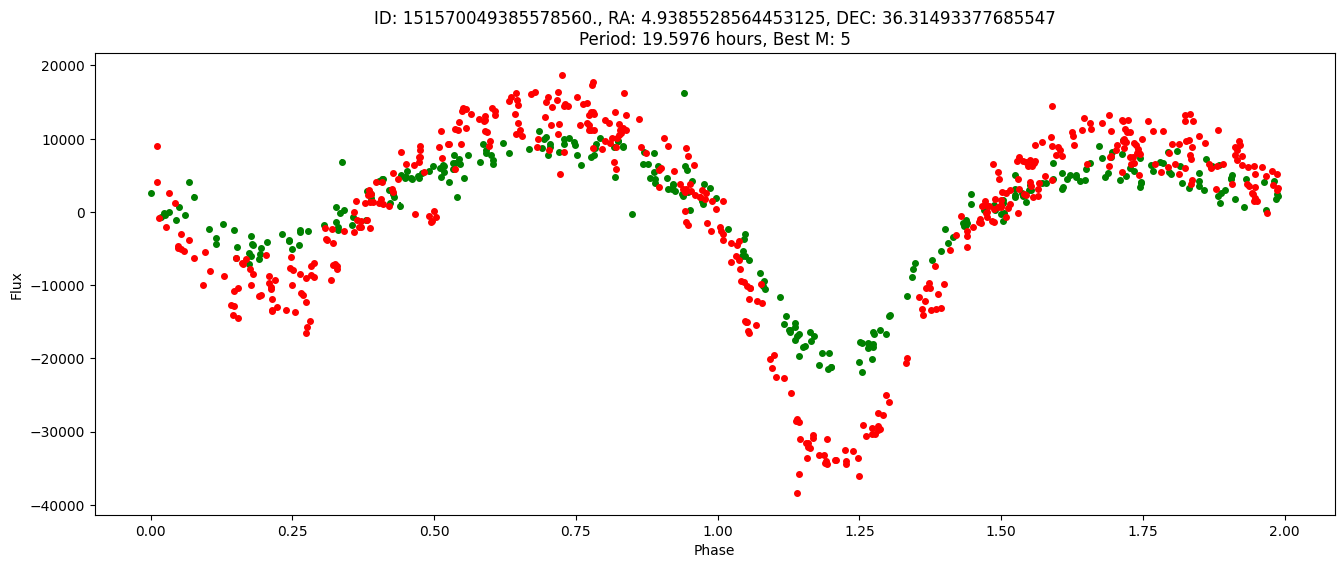

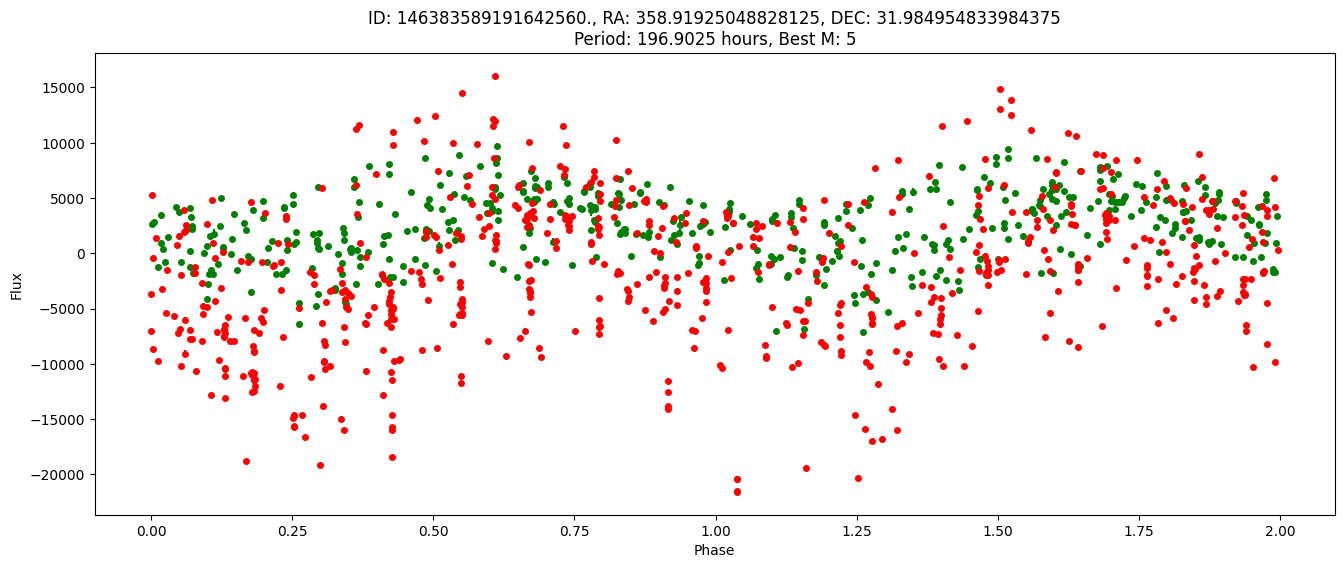

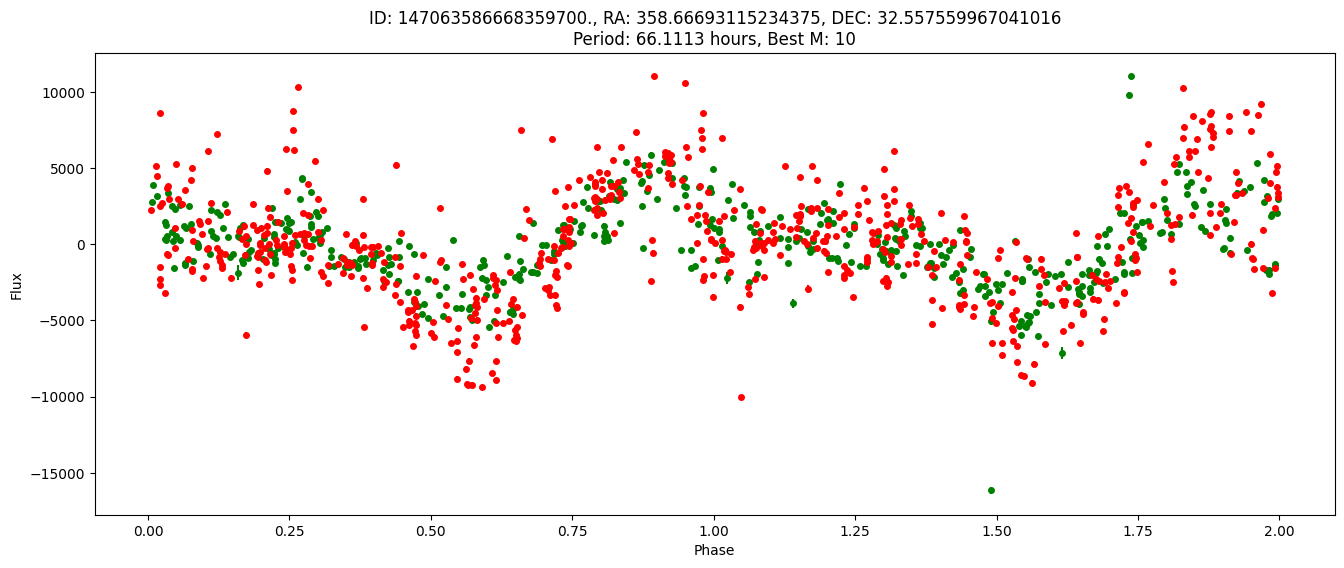

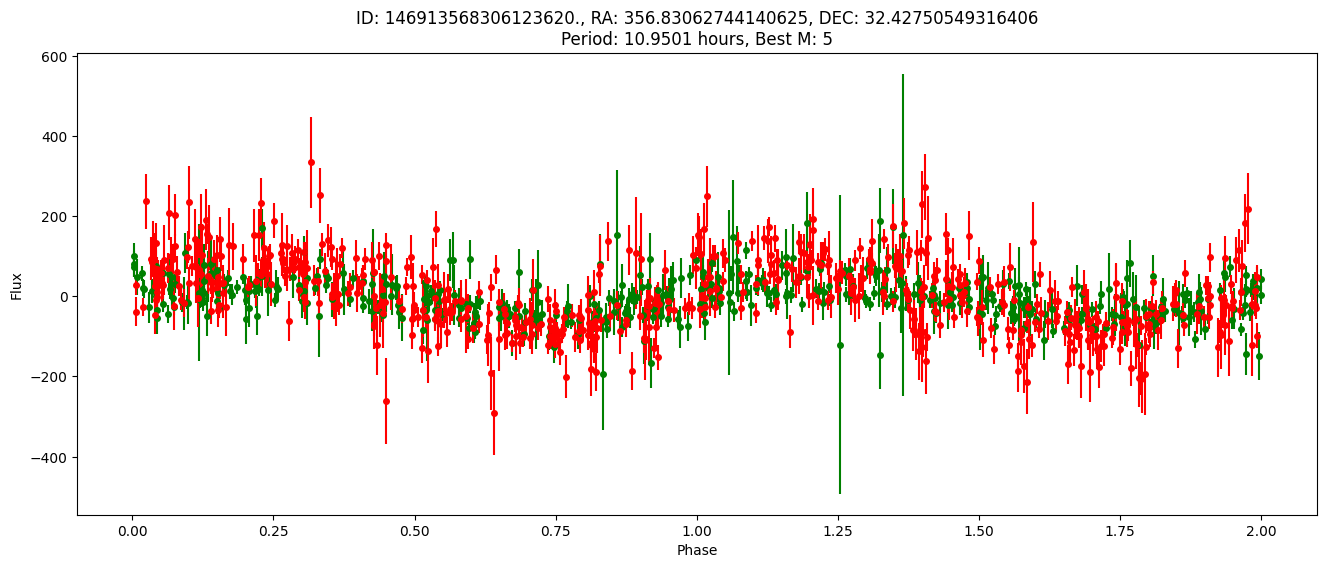

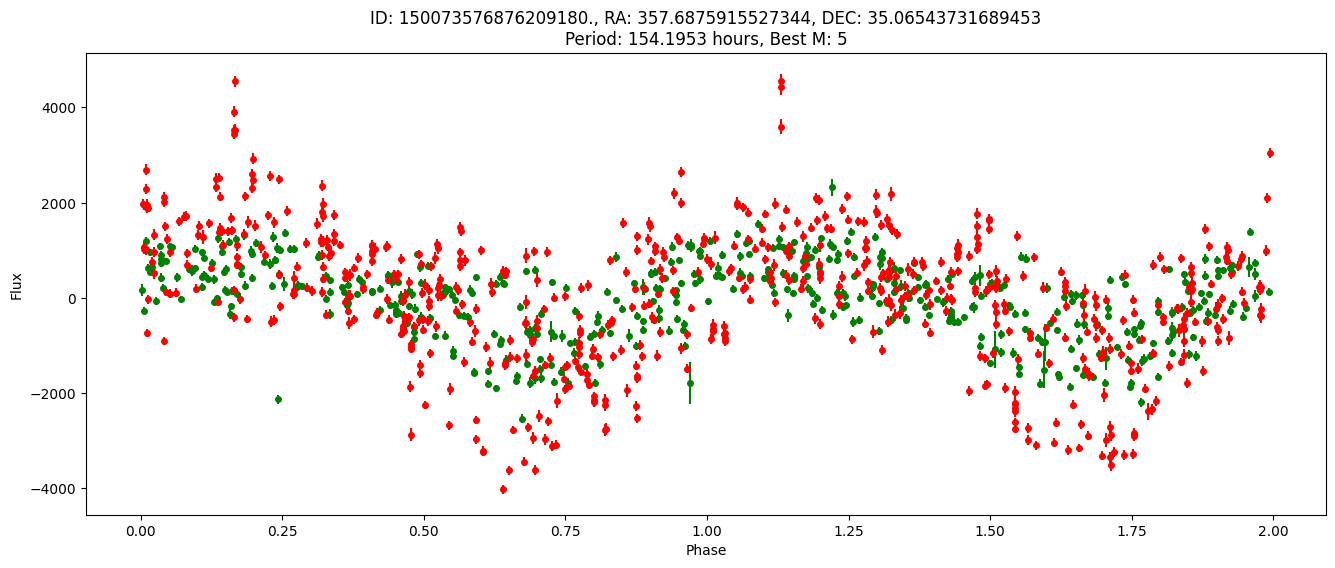

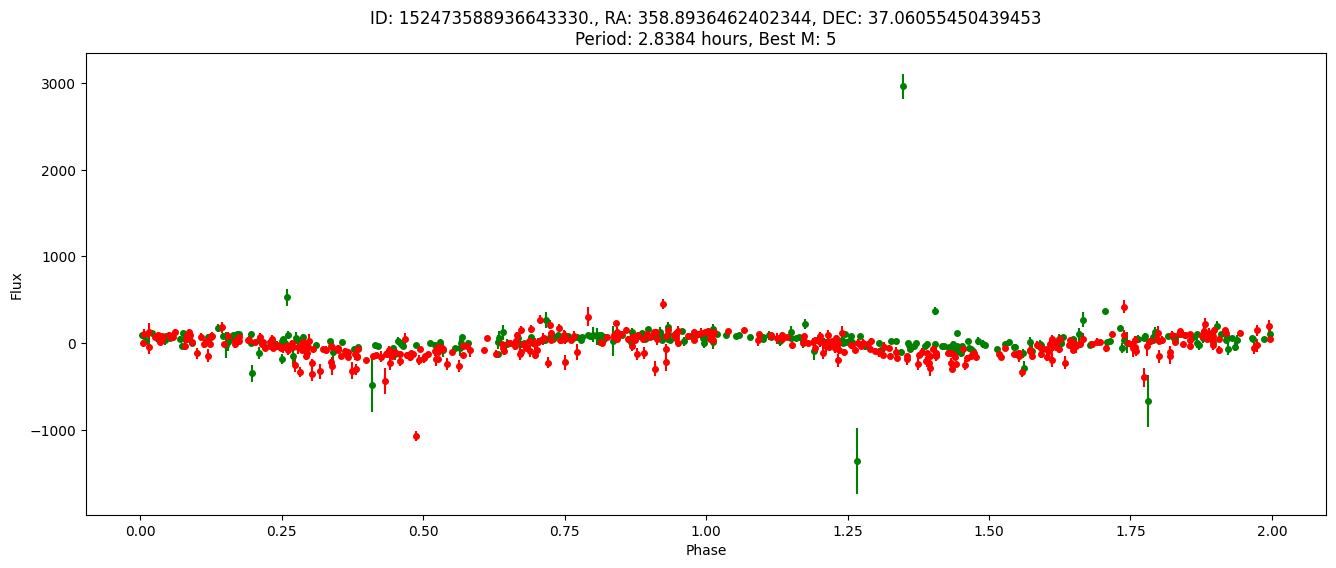

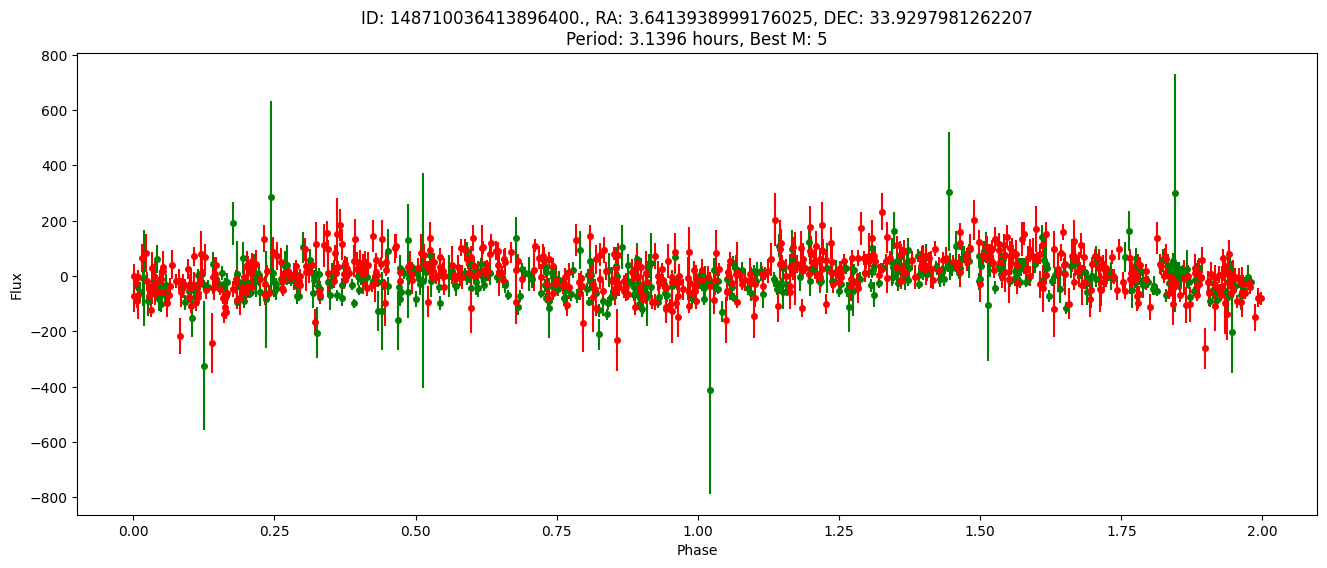

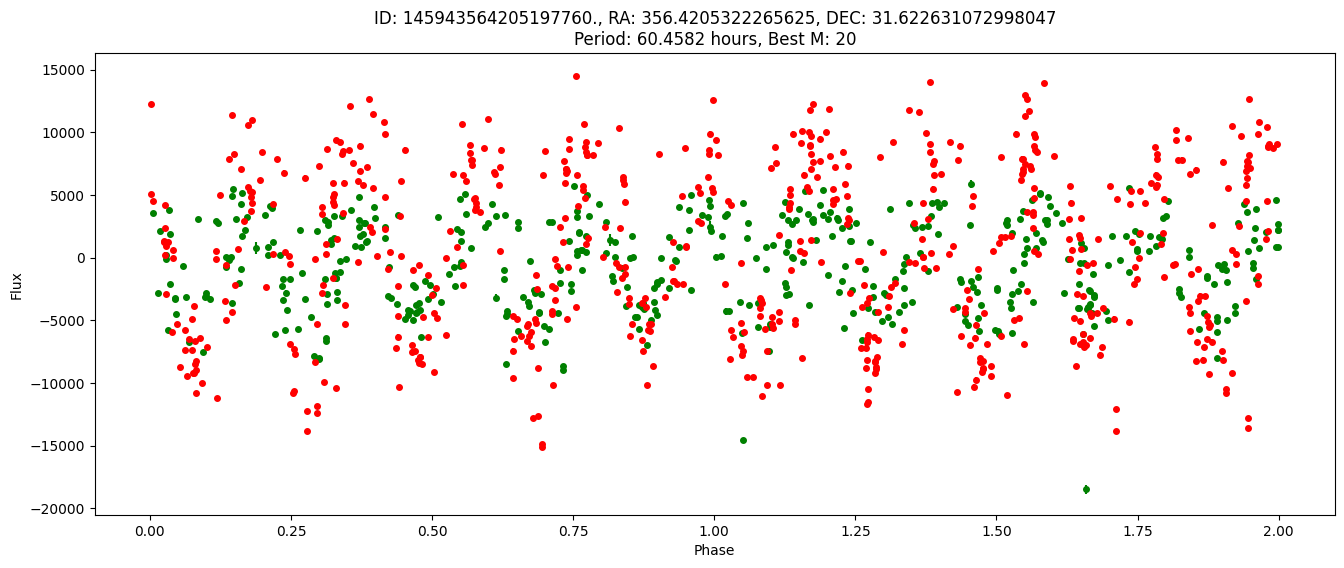

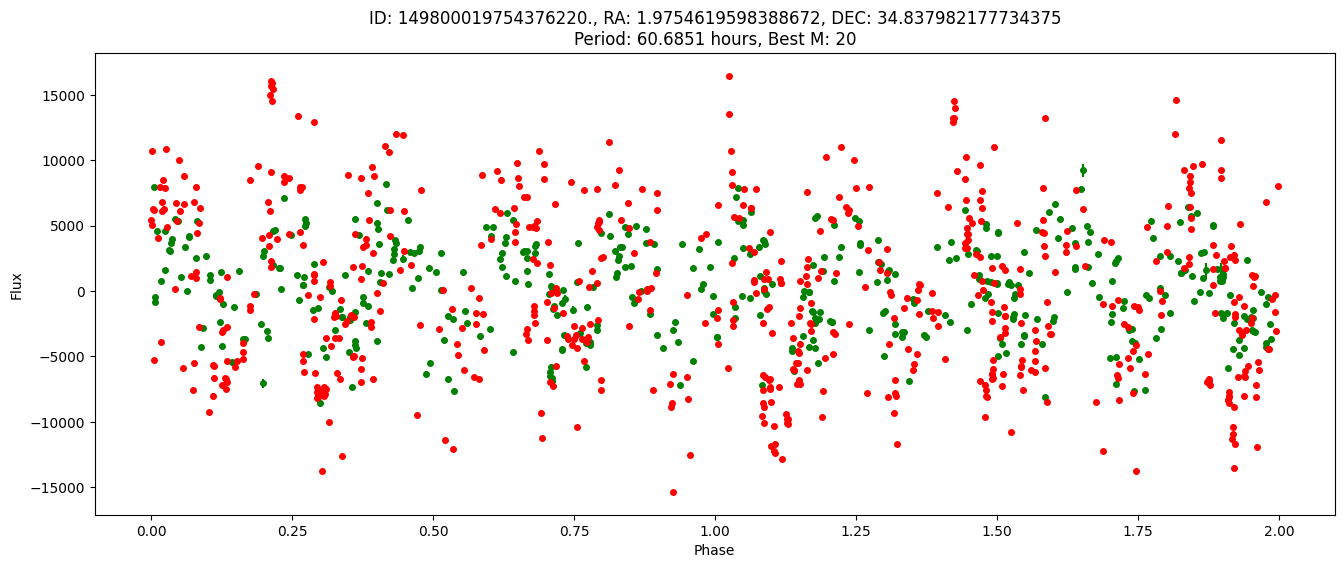

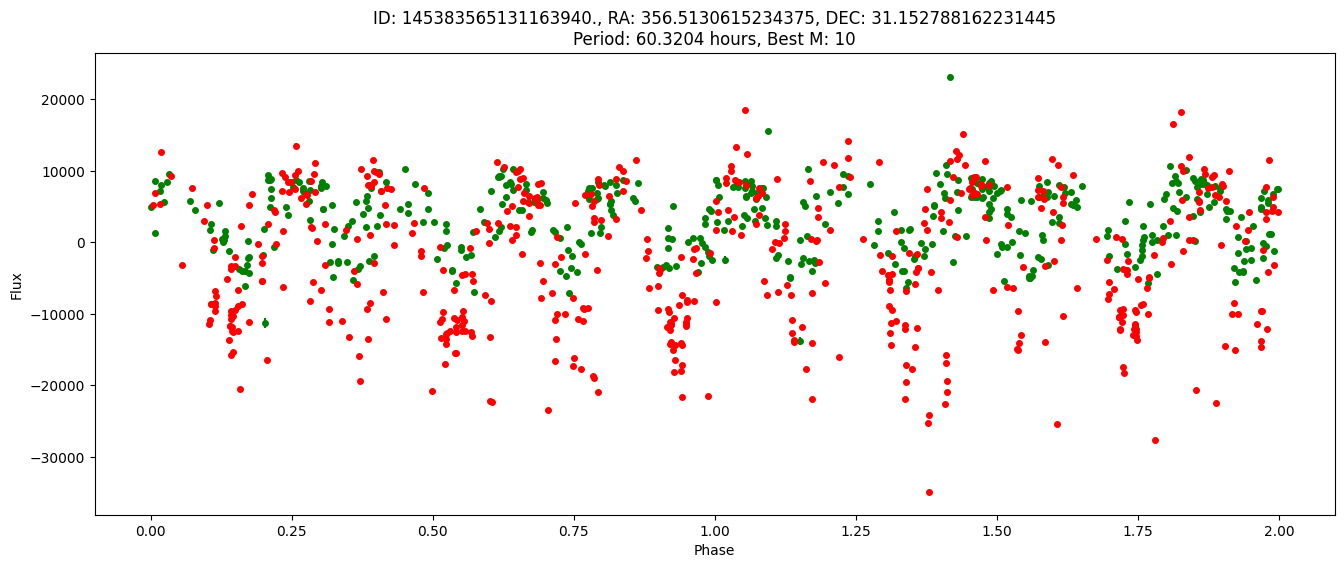

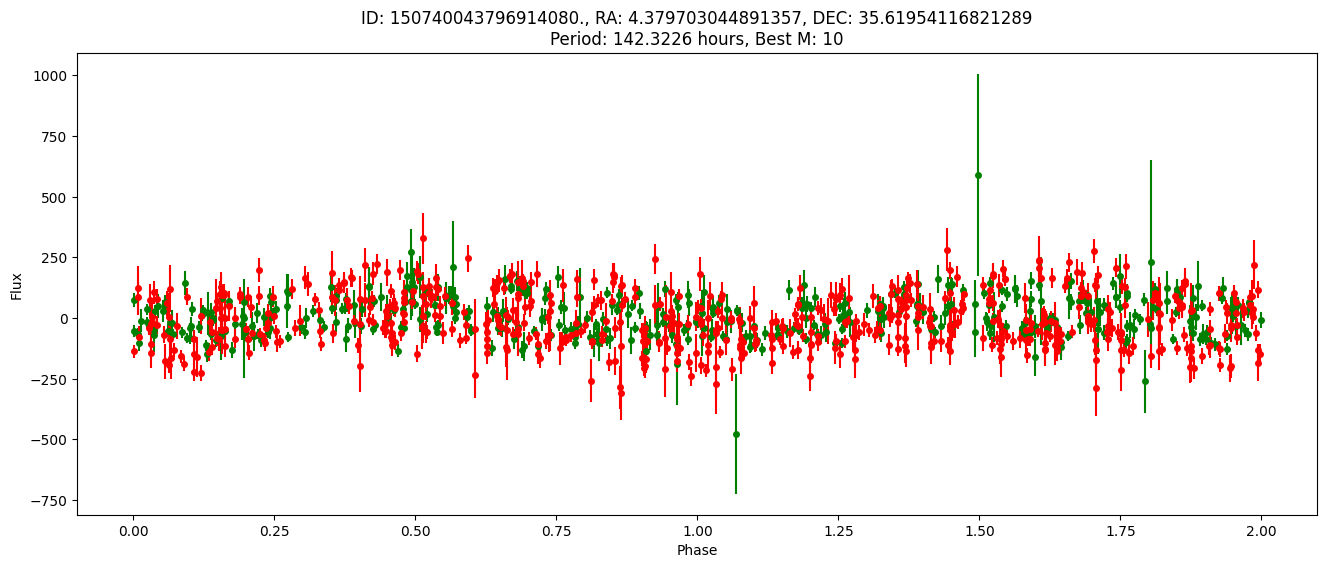

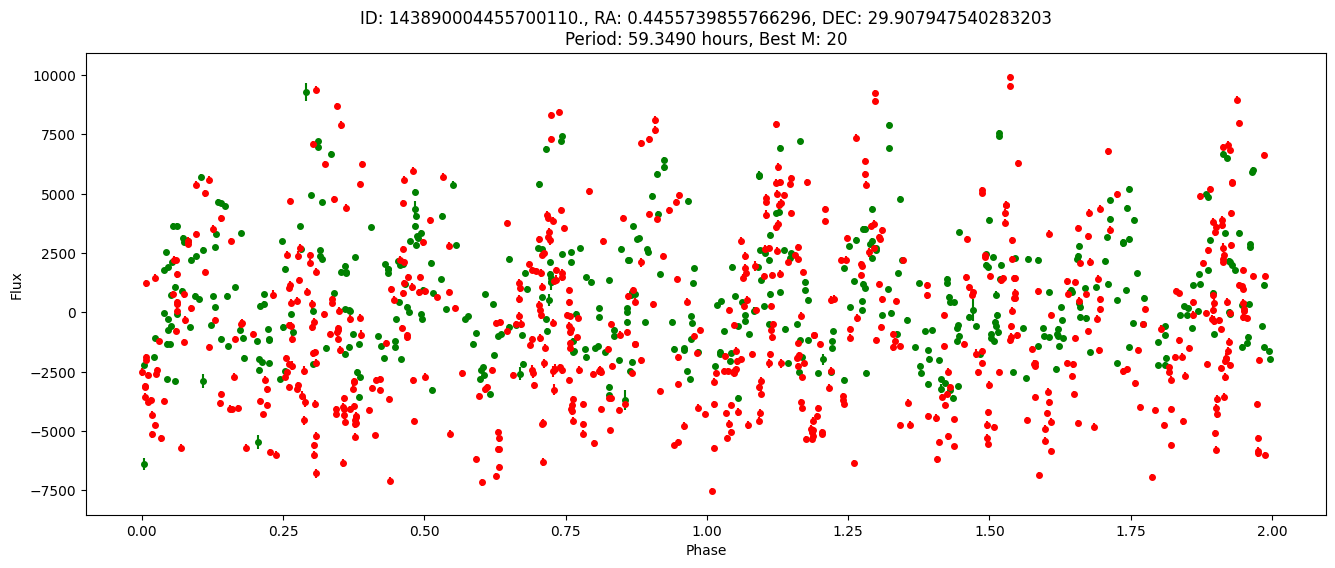

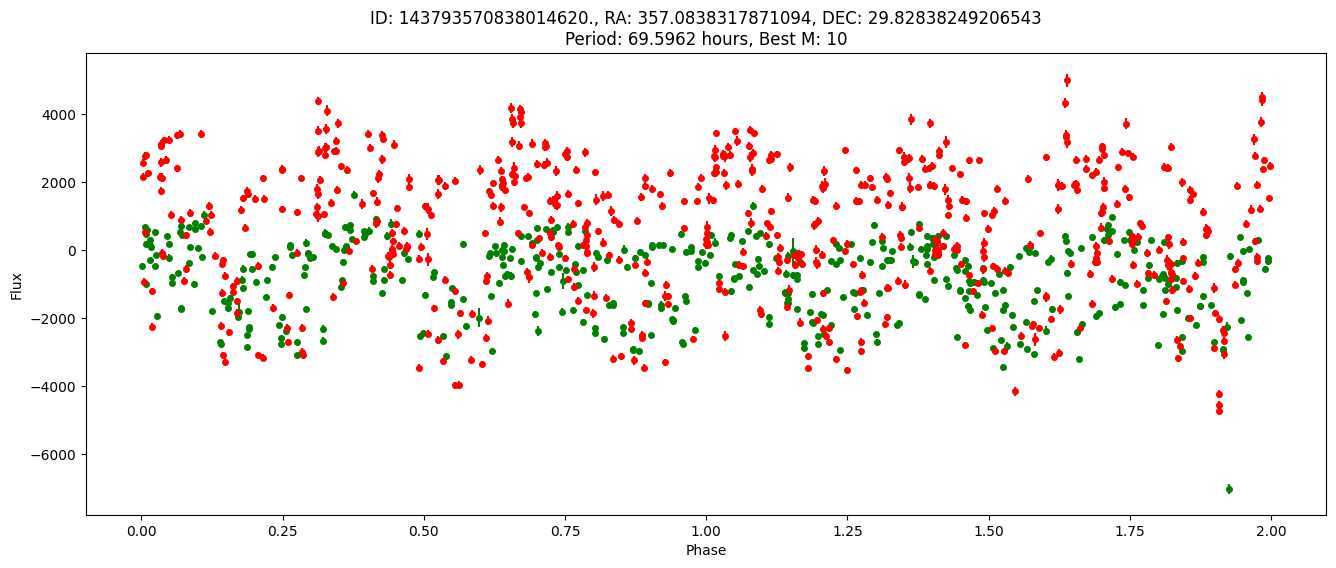

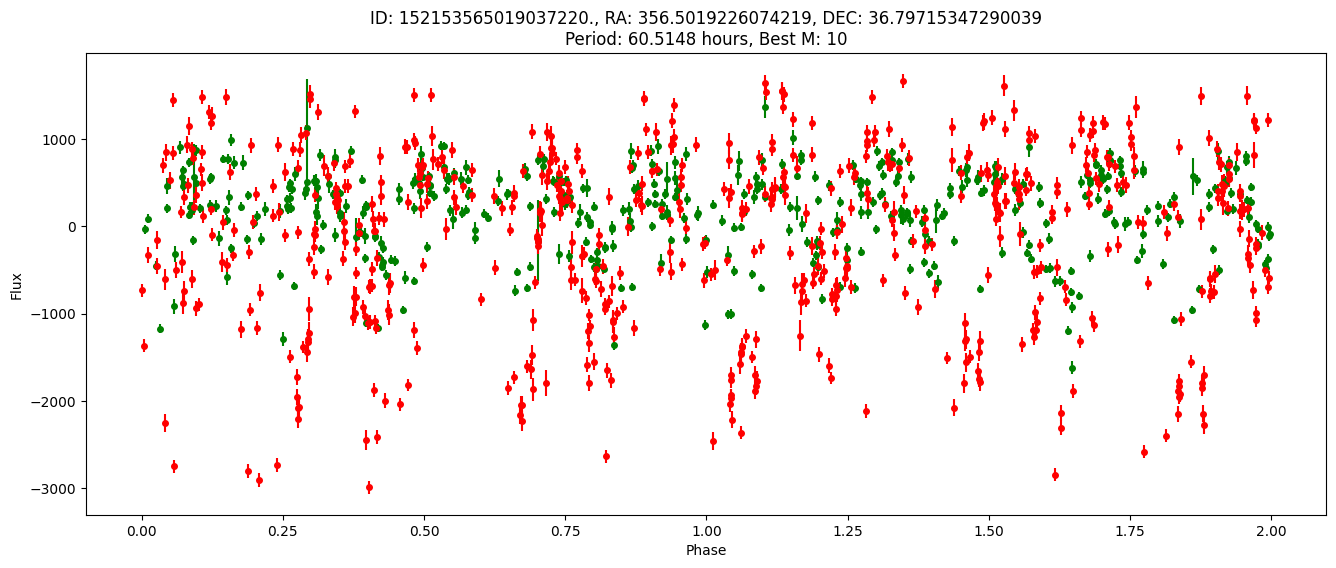

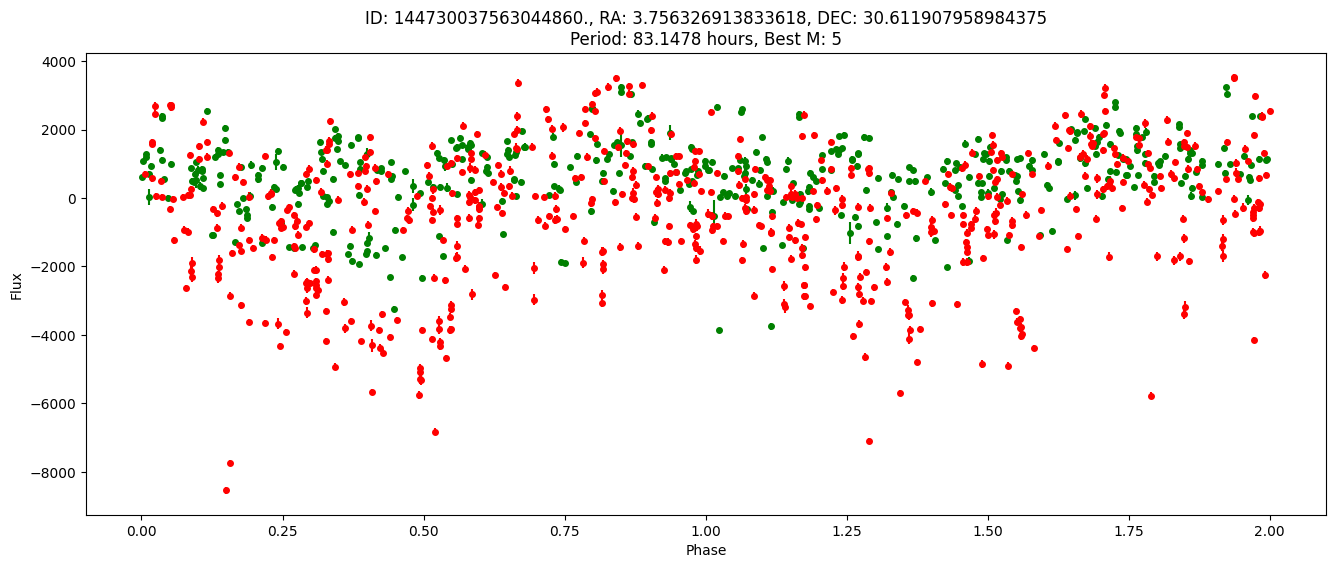

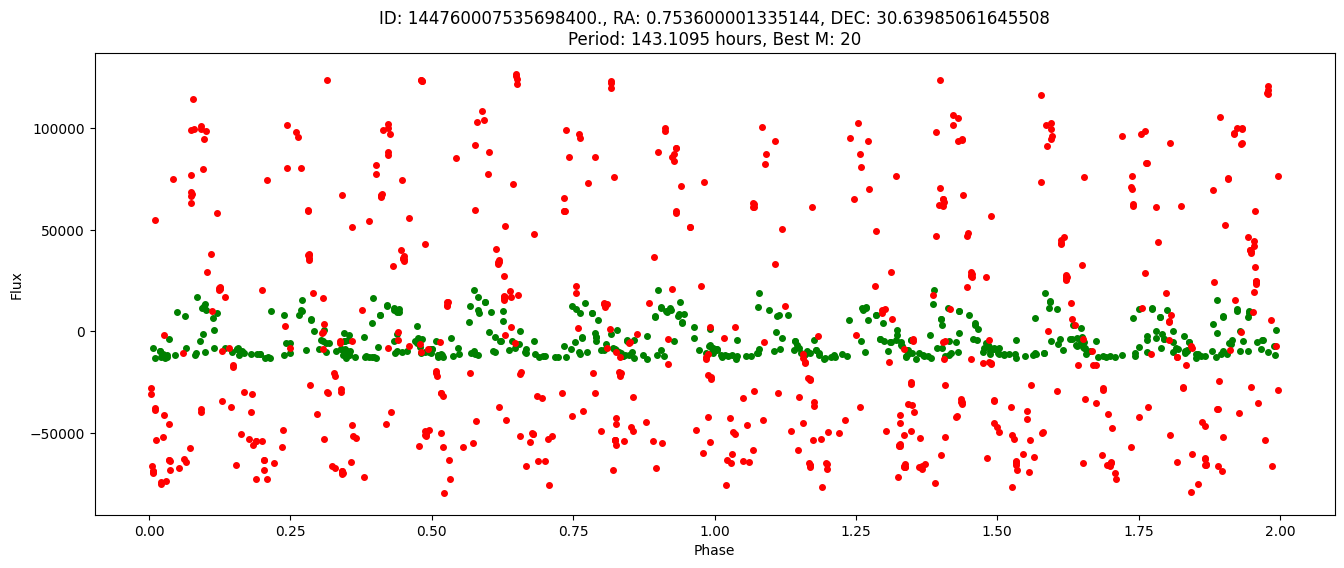

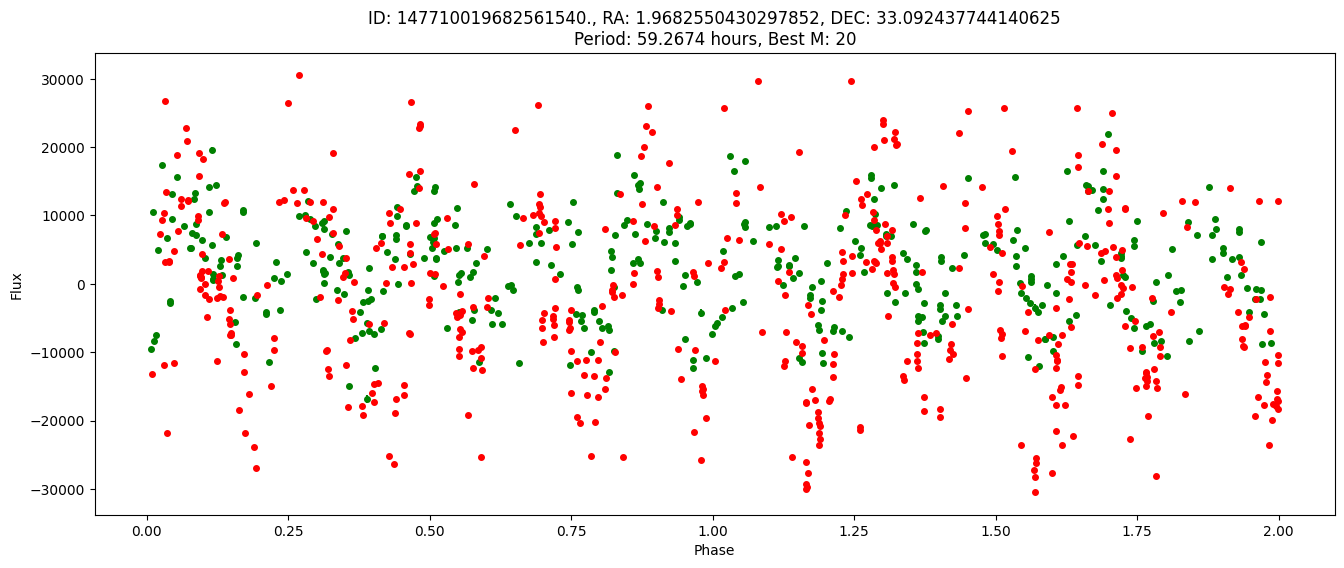

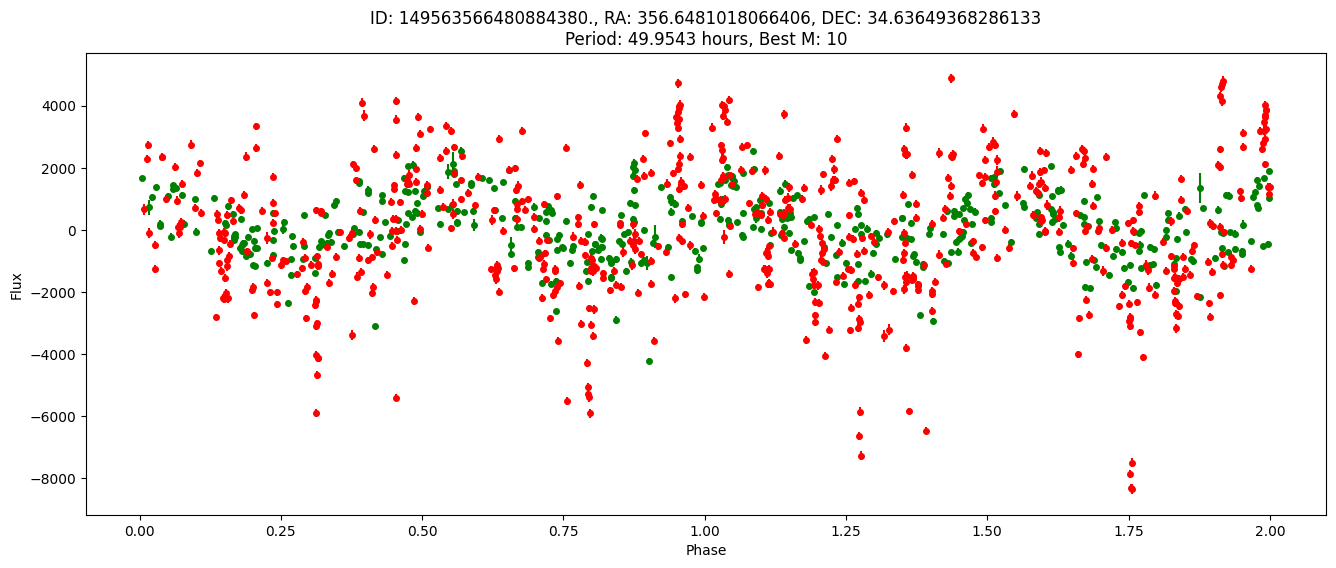

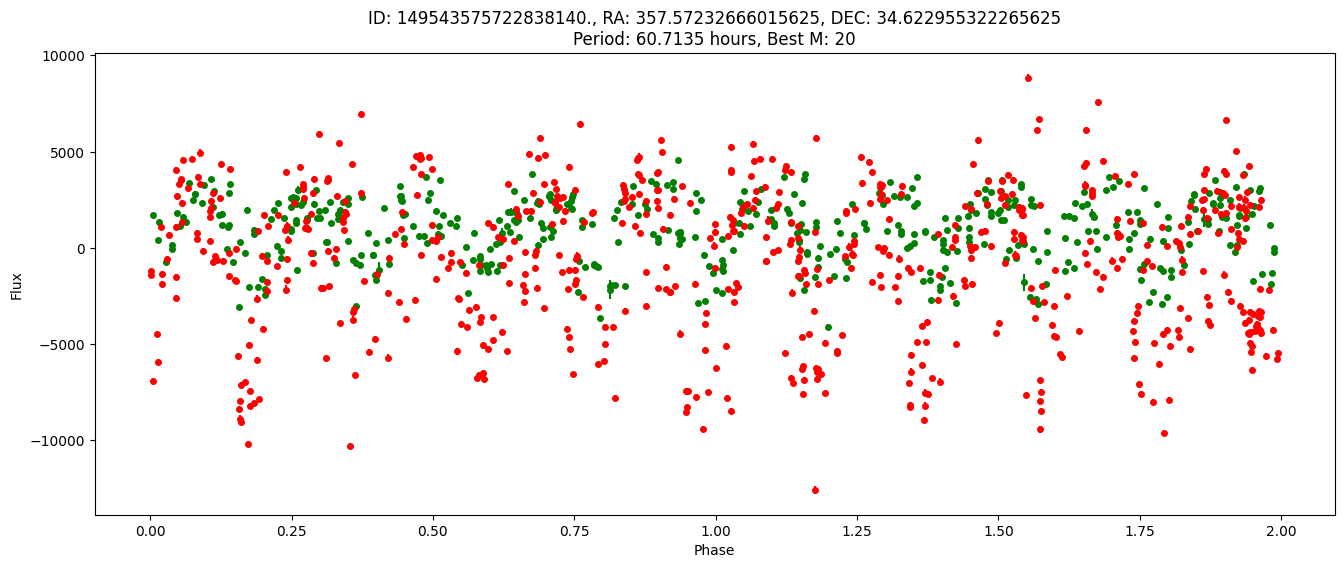

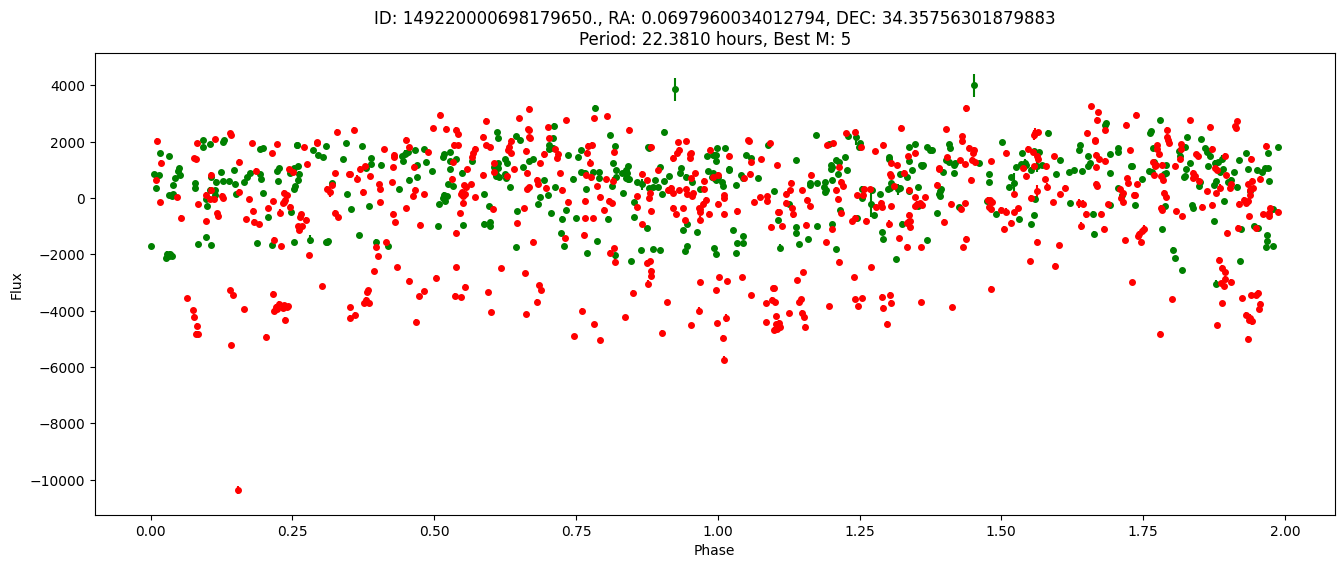

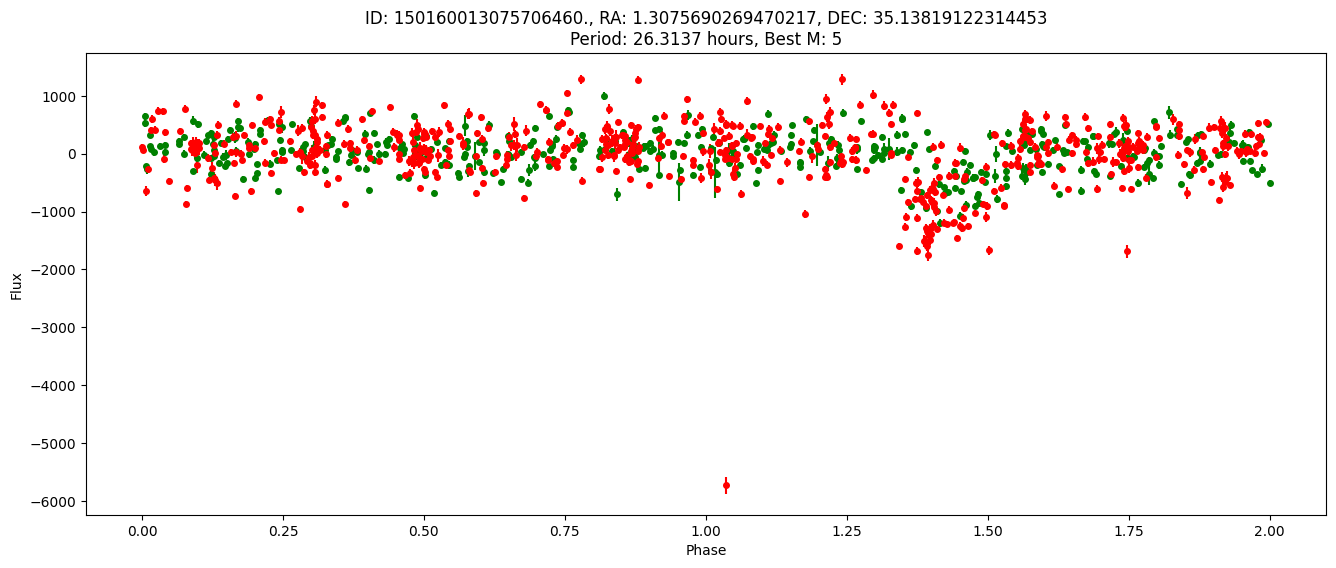

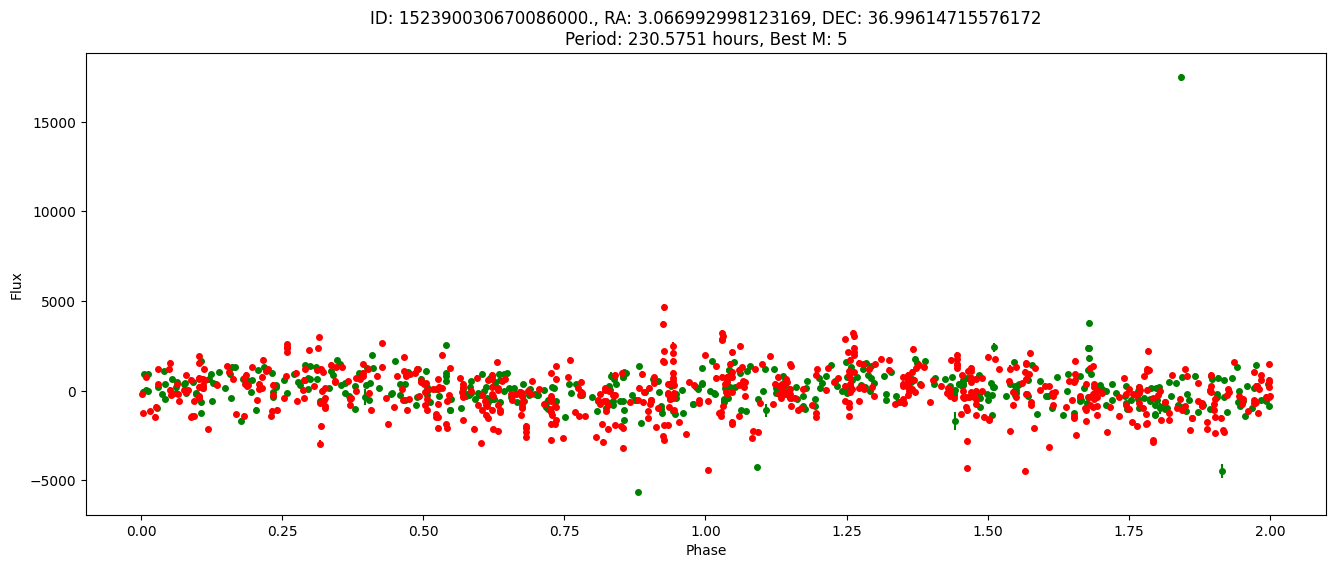

In [8]:
# let's plot their lightcurves, folded on the best period, both g an r band
all_photometry = retrieve_objs_lightcurve(giant_candidates, path_lc, ssh_client, remote_path_lc, limit_fields=[int(field)])
for candidate in giant_candidates:
    photometry = all_photometry[candidate.id]
    if len(photometry[0]) > 0:
        plot_folded_lightcurve(candidate, photometry, show_plot=True, figsize=(16,6))

In the following section, we show how to run Schuster and FPW to compute periods. This is a simple example and not necessary (at least for FPW) since we already have the top 50 peaks. However, it is a good exercise to understand how these algorithms work.

In [13]:
min_epochs = 50 # minimum number of epochs to consider a candidate

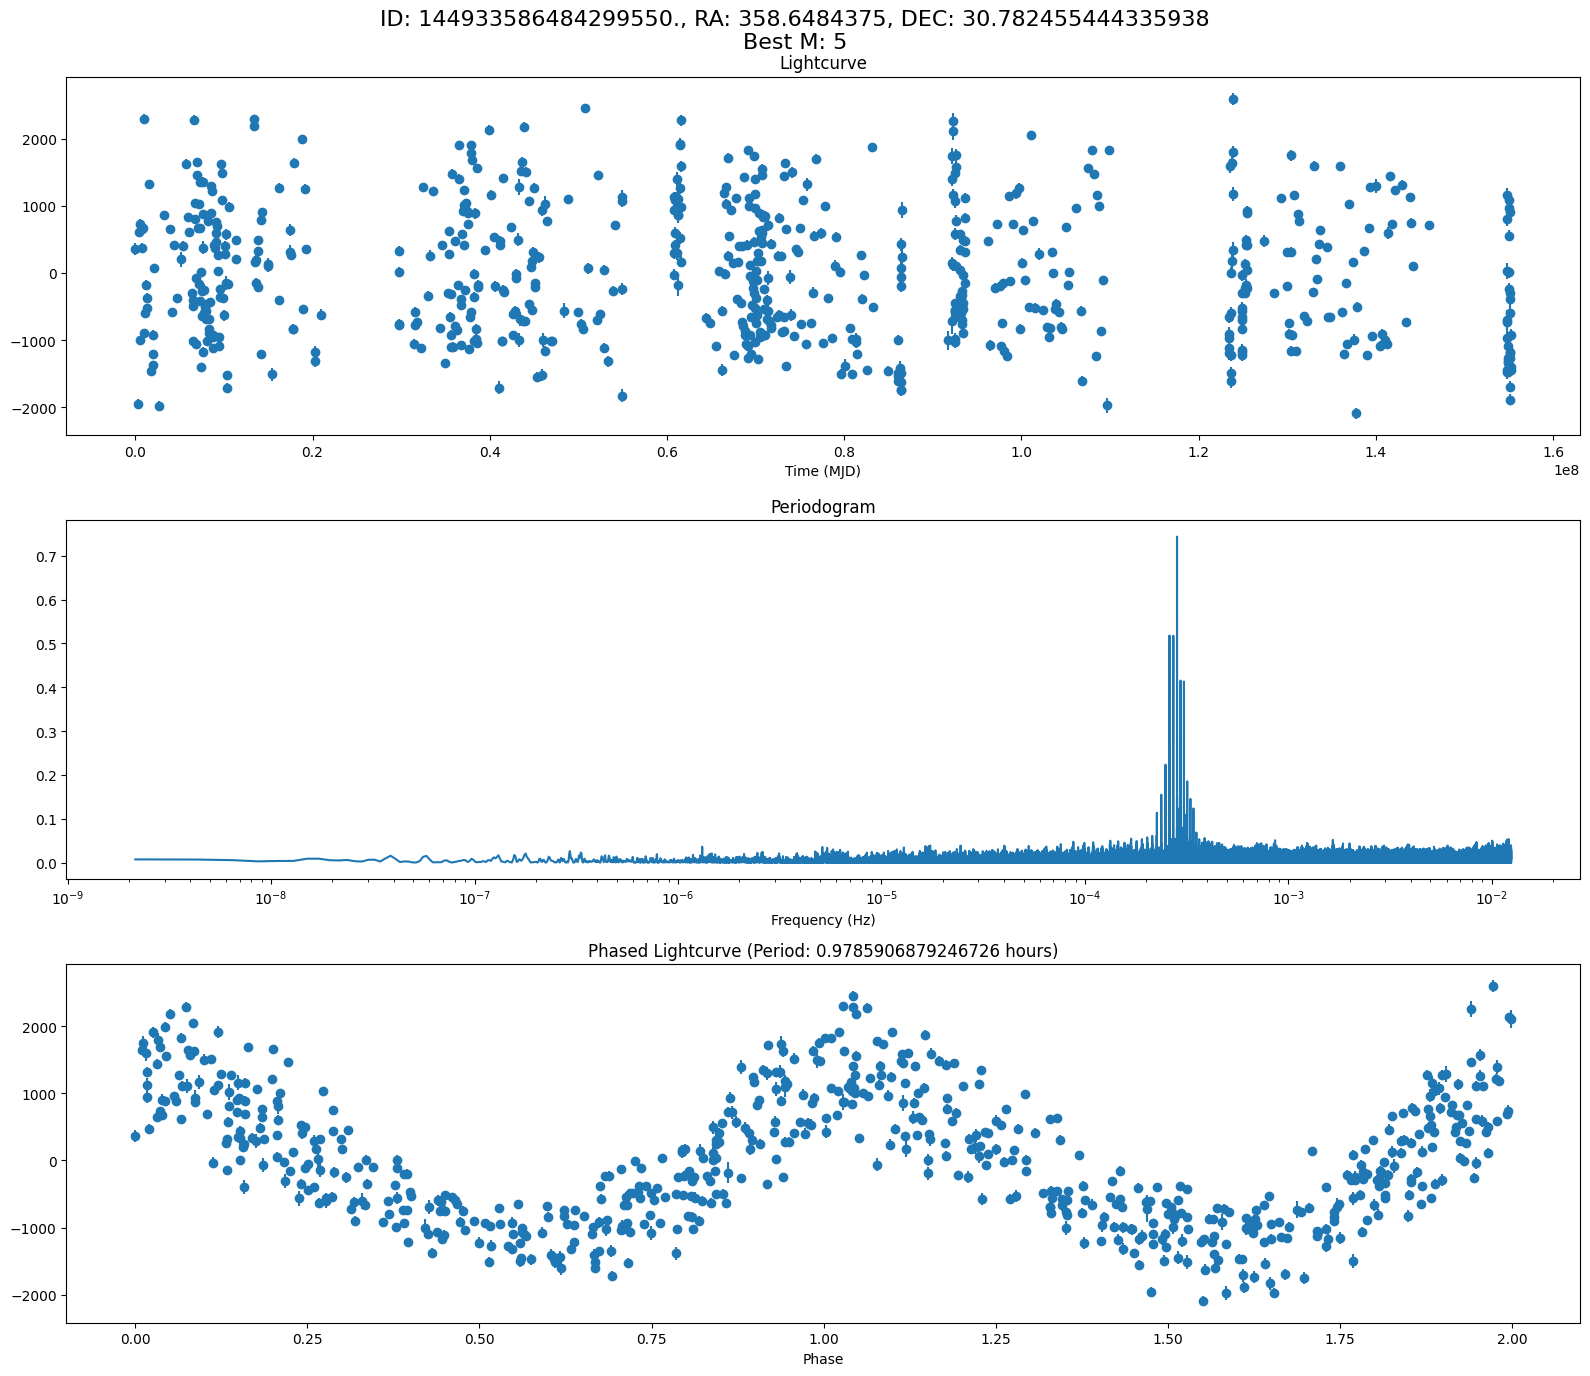

In [14]:
candidate = short_candidates[0]

phot = retrieve_objs_lightcurve([candidate], path_lc, ssh_client, remote_path_lc, bands=[band], limit_fields=[field])[candidate.id]

fgrid = freq_grid(phot[0])

ls_pgram = LombScargle(phot[0], phot[1], phot[2]).power(fgrid)
best_period = 1/fgrid[np.argmax(ls_pgram)]

plot_periodicity(candidate, phot, ls_pgram, best_period, show_plot=True, figsize=(16,14))

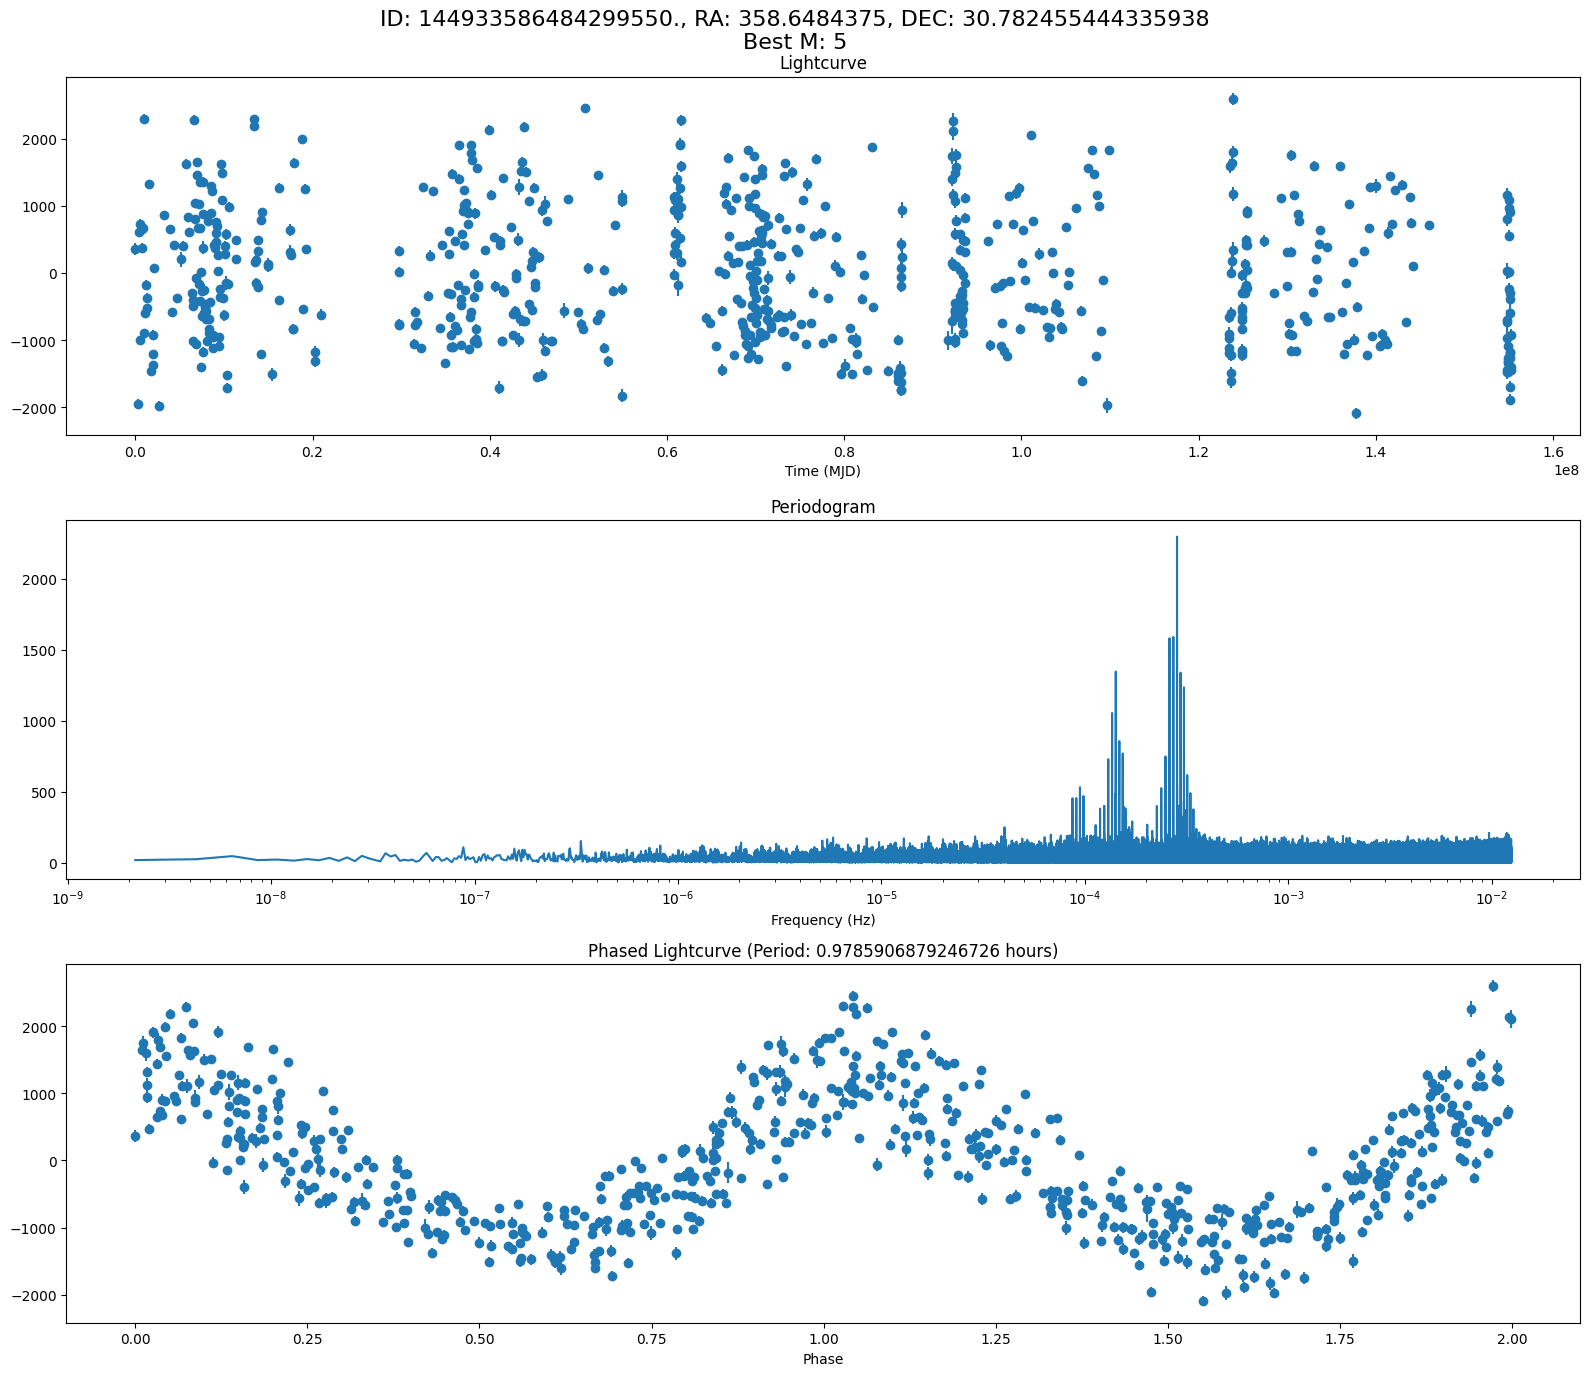

In [15]:
# Same but with Sam's FPW (needs to be installed from .whl)
if fpw is None:
    raise ImportError("Could not import fpw. You will not be able to use the fpw module.")

f_grid = freq_grid(phot[0])
fpw_pgram = fpw.run_fpw(phot[0], phot[1], phot[2], f_grid, 5)
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = 1/fgrid[np.argmax(fpw_pgram)]

plot_periodicity(candidate, phot, fpw_pgram, best_period, show_plot=True, figsize=(16,14))